In [7]:
import numpy as np
import matplotlib.pyplot as plt

class DistillationColumn:
    # Base class for the distillation column setup.
    def __init__(self, feed, distillate, bottoms, pressure, heavy_key):
        self.feed = feed
        self.distillate = distillate
        self.bottoms = bottoms
        self.pressure = pressure  # kPa
        self.heavy_key = heavy_key
        self.k_values = self.compute_k_values()
        self.relative_volatilities = self.compute_relative_volatilities()

    def compute_k_values(self):
        # Calculate K-values using K_i = yi/xi.
        k_values = {}
        total_feed = sum(self.feed.values())

        for comp in self.feed.keys():
            z_i = self.feed.get(comp, 0) / total_feed
            y_i = self.distillate.get(comp, 0) / sum(self.distillate.values())
            x_i = self.bottoms.get(comp, 0) / sum(self.bottoms.values())

            if x_i > 0:  # Avoid division by zero
                k_values[comp] = (y_i / x_i) * (1 - z_i) / (1 - y_i)
            else:
                k_values[comp] = np.nan  # Undefined K-value if x_i = 0

        return k_values

    def compute_relative_volatilities(self):
        # Calculate relative volatilities using computed K-values.
        alpha = {comp: k / self.k_values[self.heavy_key] if self.k_values[self.heavy_key] != 0 else np.nan
                 for comp, k in self.k_values.items()}
        return alpha

# ------------------ Example Usage ------------------

# Given Data
feed = {'iC4': 12, 'nC4': 448, 'iC5': 36, 'nC5': 15, 'C6': 23, 'C7': 39.1, 'C8': 272.2, 'C9': 31.0}
distillate = {'iC4': 12, 'nC4': 442, 'iC5': 13, 'nC5': 1}
bottoms = {'nC4': 6, 'iC5': 23, 'nC5': 14, 'C6': 23, 'C7': 39.1, 'C8': 272.2, 'C9': 31.0}

pressure = 552  # kPa

heavy_key = 'iC5'
low_key = 'nC4'

distillate = DistillationColumn(feed,distillate,bottoms,pressure,heavy_key=heavy_key)
print(distillate.compute_k_values())
print(distillate.compute_relative_volatilities())



{'iC4': nan, 'nC4': 565.4214937806684, 'iC5': 0.4863680650504698, 'nC5': 0.061381302409352266, 'C6': 0.0, 'C7': 0.0, 'C8': 0.0, 'C9': 0.0}
{'iC4': nan, 'nC4': 1162.5382799793717, 'iC5': 1.0, 'nC5': 0.12620339783818416, 'C6': 0.0, 'C7': 0.0, 'C8': 0.0, 'C9': 0.0}


N_min: 1.0, R_min: nan


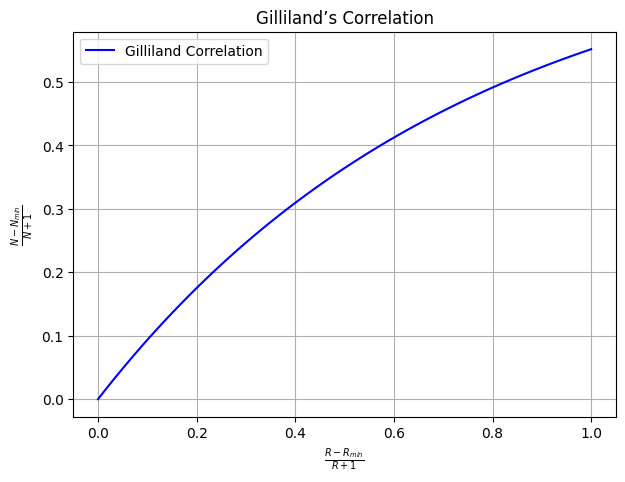

In [8]:
import numpy as np
import matplotlib.pyplot as plt

class DistillationColumn:
    # Base class for the distillation column setup.
    def __init__(self, feed, distillate, bottoms, pressure, heavy_key):
        self.feed = feed
        self.distillate = distillate
        self.bottoms = bottoms
        self.pressure = pressure  # kPa
        self.heavy_key = heavy_key
        self.k_values = self.compute_k_values()
        self.relative_volatilities = self.compute_relative_volatilities()

    def compute_k_values(self):
        # Calculate K-values using K_i = yi/xi.
        k_values = {}
        total_distillate = sum(self.distillate.values())
        total_bottoms = sum(self.bottoms.values())

        for comp in self.feed.keys():
            y_i = self.distillate.get(comp, 0) / total_distillate
            x_i = self.bottoms.get(comp, 0) / total_bottoms

            if x_i > 0:  # Avoid division by zero
                k_values[comp] = y_i / x_i
            else:
                k_values[comp] = np.nan  # Undefined K-value if x_i = 0

        return k_values

    def compute_relative_volatilities(self):
        # Calculate relative volatilities using computed K-values.
        alpha = {comp: k / self.k_values[self.heavy_key] if self.k_values[self.heavy_key] != 0 else np.nan
                 for comp, k in self.k_values.items()}
        return alpha

class Fenske(DistillationColumn):
    # Calculates minimum equilibrium stages using the Fenske equation.
    def __init__(self, feed, distillate, bottoms, pressure, light_key, heavy_key):
        super().__init__(feed, distillate, bottoms, pressure, heavy_key)
        self.light_key = light_key

    def compute_N_min(self):
        # Calculate minimum equilibrium stages (N_min) using Fenske equation.
        xD_LK = self.distillate[self.light_key] / sum(self.distillate.values())
        xB_LK = self.bottoms[self.light_key] / sum(self.bottoms.values())
        xD_HK = self.distillate[self.heavy_key] / sum(self.distillate.values())
        xB_HK = self.bottoms[self.heavy_key] / sum(self.bottoms.values())

        alpha = self.relative_volatilities[self.light_key]
        N_min = np.log((xD_LK / xB_LK) * (xB_HK / xD_HK)) / np.log(alpha)

        return round(N_min, 2)

    def estimate_nonkey_distribution(self):
        # Estimate the distribution of non-key components using the Fenske equation.
        distributions = {}
        for comp, alpha in self.relative_volatilities.items():
            if comp not in [self.light_key, self.heavy_key]:
                xD = self.distillate.get(comp, 0) / sum(self.distillate.values())
                xB = xD / (alpha ** self.compute_N_min())  # Estimate based on Fenske
                distributions[comp] = round(xB * sum(self.bottoms.values()), 2)
        return distributions

class Underwood(DistillationColumn):
    # Computes the minimum reflux ratio using Underwood equation.
    def __init__(self, feed, distillate, bottoms, pressure, light_key, heavy_key):
        super().__init__(feed, distillate, bottoms, pressure, heavy_key)
        self.light_key = light_key

    def compute_R_min(self):
        # Calculate the minimum reflux ratio (R_min) using Underwood equation.
        alpha_LK = self.relative_volatilities[self.light_key]
        theta = 0.5 * alpha_LK  # Approximate theta value
        sum_terms = sum(self.distillate[comp] / (self.relative_volatilities[comp] - theta) 
                        for comp in self.distillate if comp in self.relative_volatilities)

        R_min = sum_terms - 1
        return round(R_min, 2)

class Gilliland:
    # Estimates actual stages using Gilliland's correlation.
    @staticmethod
    def compute_actual_stages(N_min, R_min, reflux_ratio):
        # Estimate actual equilibrium stages using Gilliland's empirical correlation.
        R = reflux_ratio * R_min
        X = (R - R_min) / (R + 1)
        Y = 0.75 * (1 - np.exp(-1.33 * X))  # Approximate Gilliland's function
        N_actual = (Y * (N_min + 1)) / (1 - Y)

        return round(N_actual, 2)

    @staticmethod
    def plot_gilliland():
        # Plot Gilliland's correlation curve.
        X_values = np.linspace(0, 1, 100)
        Y_values = 0.75 * (1 - np.exp(-1.33 * X_values))

        plt.figure(figsize=(7, 5))
        plt.plot(X_values, Y_values, label="Gilliland Correlation", color="b")
        plt.xlabel(r"$\frac{R - R_{min}}{R + 1}$")
        plt.ylabel(r"$\frac{N - N_{min}}{N + 1}$")
        plt.title("Gilliland’s Correlation")
        plt.legend()
        plt.grid()
        plt.show()

# ------------------ Example Usage ------------------

# Given Data
feed = {'iC4': 12, 'nC4': 448, 'iC5': 36, 'nC5': 15, 'C6': 23, 'C7': 39.1, 'C8': 272.2, 'C9': 31.0}
distillate = {'iC4': 12, 'nC4': 442, 'iC5': 13, 'nC5': 1}
bottoms = {'nC4': 6, 'iC5': 23, 'nC5': 14, 'C6': 23, 'C7': 39.1, 'C8': 272.2, 'C9': 31.0}

pressure = 552  # kPa

# Run Calculations
fenske = Fenske(feed, distillate, bottoms, pressure, 'nC4', 'iC5')
N_min = fenske.compute_N_min()
R_min = Underwood(feed, distillate, bottoms, pressure, 'nC4', 'iC5').compute_R_min()

print(f"N_min: {N_min}, R_min: {R_min}")
Gilliland.plot_gilliland()


N_min: 1.0, R_min: nan


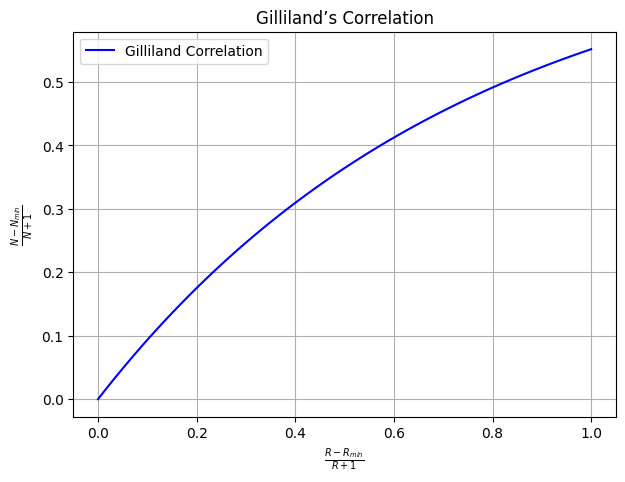

In [9]:
import numpy as np
import matplotlib.pyplot as plt

class DistillationColumn:
    # Base class for the distillation column setup.
    def __init__(self, feed, distillate, bottoms, pressure, heavy_key):
        self.feed = feed
        self.distillate = distillate
        self.bottoms = bottoms
        self.pressure = pressure  # kPa
        self.heavy_key = heavy_key
        self.k_values = self.compute_k_values()
        self.relative_volatilities = self.compute_relative_volatilities()

    def compute_k_values(self):
        # Calculate K-values using K_i = yi/xi.
        k_values = {}
        total_distillate = sum(self.distillate.values())
        total_bottoms = sum(self.bottoms.values())

        for comp in self.feed.keys():
            y_i = self.distillate.get(comp, 0) / total_distillate
            x_i = self.bottoms.get(comp, 0) / total_bottoms

            if x_i > 0:  # Avoid division by zero
                k_values[comp] = y_i / x_i
            else:
                k_values[comp] = np.nan  # Undefined K-value if x_i = 0

        return k_values

    def compute_relative_volatilities(self):
        # Calculate relative volatilities using computed K-values.
        alpha = {comp: k / self.k_values[self.heavy_key] if self.k_values[self.heavy_key] != 0 else np.nan
                 for comp, k in self.k_values.items()}
        return alpha

class Fenske(DistillationColumn):
    # Calculates minimum equilibrium stages using the Fenske equation.
    def __init__(self, feed, distillate, bottoms, pressure, light_key, heavy_key):
        super().__init__(feed, distillate, bottoms, pressure, heavy_key)
        self.light_key = light_key

    def compute_N_min(self):
        # Calculate minimum equilibrium stages (N_min) using Fenske equation.
        xD_LK = self.distillate[self.light_key] / sum(self.distillate.values())
        xB_LK = self.bottoms[self.light_key] / sum(self.bottoms.values())
        xD_HK = self.distillate[self.heavy_key] / sum(self.distillate.values())
        xB_HK = self.bottoms[self.heavy_key] / sum(self.bottoms.values())

        alpha = self.relative_volatilities[self.light_key]
        N_min = np.log((xD_LK / xB_LK) * (xB_HK / xD_HK)) / np.log(alpha)

        return round(N_min, 2)

    def estimate_nonkey_distribution(self):
        # Estimate the distribution of non-key components using the Fenske equation.
        distributions = {}
        for comp, alpha in self.relative_volatilities.items():
            if comp not in [self.light_key, self.heavy_key]:
                xD = self.distillate.get(comp, 0) / sum(self.distillate.values())
                xB = xD / (alpha ** self.compute_N_min())  # Estimate based on Fenske
                distributions[comp] = round(xB * sum(self.bottoms.values()), 2)
        return distributions

class Underwood(DistillationColumn):
    # Computes the minimum reflux ratio using Underwood equation.
    def __init__(self, feed, distillate, bottoms, pressure, light_key, heavy_key):
        super().__init__(feed, distillate, bottoms, pressure, heavy_key)
        self.light_key = light_key

    def compute_R_min(self):
        # Calculate the minimum reflux ratio (R_min) using Underwood equation.
        alpha_LK = self.relative_volatilities[self.light_key]
        theta = 0.5 * alpha_LK  # Approximate theta value
        sum_terms = sum(self.distillate[comp] / (self.relative_volatilities[comp] - theta) 
                        for comp in self.distillate if comp in self.relative_volatilities)

        R_min = sum_terms - 1
        return round(R_min, 2)

class Gilliland:
    # Estimates actual stages using Gilliland's correlation.
    @staticmethod
    def compute_actual_stages(N_min, R_min, reflux_ratio):
        # Estimate actual equilibrium stages using Gilliland's empirical correlation.
        R = reflux_ratio * R_min
        X = (R - R_min) / (R + 1)
        Y = 0.75 * (1 - np.exp(-1.33 * X))  # Approximate Gilliland's function
        N_actual = (Y * (N_min + 1)) / (1 - Y)

        return round(N_actual, 2)

    @staticmethod
    def plot_gilliland():
        # Plot Gilliland's correlation curve.
        X_values = np.linspace(0, 1, 100)
        Y_values = 0.75 * (1 - np.exp(-1.33 * X_values))

        plt.figure(figsize=(7, 5))
        plt.plot(X_values, Y_values, label="Gilliland Correlation", color="b")
        plt.xlabel(r"$\frac{R - R_{min}}{R + 1}$")
        plt.ylabel(r"$\frac{N - N_{min}}{N + 1}$")
        plt.title("Gilliland’s Correlation")
        plt.legend()
        plt.grid()
        plt.show()

# ------------------ Example Usage ------------------

# Given Data
feed = {'iC4': 12, 'nC4': 448, 'iC5': 36, 'nC5': 15, 'C6': 23, 'C7': 39.1, 'C8': 272.2, 'C9': 31.0}
distillate = {'iC4': 12, 'nC4': 442, 'iC5': 13, 'nC5': 1}
bottoms = {'nC4': 6, 'iC5': 23, 'nC5': 14, 'C6': 23, 'C7': 39.1, 'C8': 272.2, 'C9': 31.0}

pressure = 552  # kPa

# Run Calculations
fenske = Fenske(feed, distillate, bottoms, pressure, 'nC4', 'iC5')
N_min = fenske.compute_N_min()
R_min = Underwood(feed, distillate, bottoms, pressure, 'nC4', 'iC5').compute_R_min()

print(f"N_min: {N_min}, R_min: {R_min}")
Gilliland.plot_gilliland()


In [16]:
import numpy as np

# Given data
components = ['IC4', 'nC4', 'IC5', 'nC5', 'C6', 'C7', 'C8', 'C9']
feed_flow = np.array([12, 448, 36, 15, 23, 39.1, 272.2, 31.0])
distillate_flow = np.array([12, 442, 13, 1, 0, 0, 0, 0])
bottoms_flow = np.array([0, 6, 23, 14, 23, 39.1, 272.2, 31.0])

# Ideal K-values at 80 psia (assumed values, replace with actual data if available)
K_values = np.array([1.5, 1.2, 0.8, 0.7, 0.5, 0.4, 0.3, 0.2])

# Part (a): Estimate Nmin using the Fenske equation
def fenske_equation(alpha_LK_HK, x_LK_dist, x_HK_dist, x_LK_bottoms, x_HK_bottoms):
    return np.log((x_LK_dist / x_HK_dist) * (x_HK_bottoms / x_LK_bottoms)) / np.log(alpha_LK_HK)

alpha_LK_HK = K_values[1] / K_values[2]  # alpha for nC4 (LK) and IC5 (HK)
x_LK_dist = distillate_flow[1] / np.sum(distillate_flow)
x_HK_dist = distillate_flow[2] / np.sum(distillate_flow)
x_LK_bottoms = bottoms_flow[1] / np.sum(bottoms_flow)
x_HK_bottoms = bottoms_flow[2] / np.sum(bottoms_flow)

Nmin = fenske_equation(alpha_LK_HK, x_LK_dist, x_HK_dist, x_LK_bottoms, x_HK_bottoms)
print(f"Minimum number of theoretical stages (Nmin): {Nmin:.2f}")

# Part (c): Calculate the minimum reflux using the Underwood equation
def underwood_equation(alpha, q, x_feed):
    # Find theta such that sum(alpha * x_feed / (alpha - theta)) = 1 - q
    # theta must be between the smallest and largest alpha values but not equal to any alpha
    theta_values = np.linspace(min(alpha) + 1e-6, max(alpha) - 1e-6, 10000)  # Increased resolution
    for theta in theta_values:
        sum_value = np.sum(alpha * x_feed / (alpha - theta))
        if np.isclose(sum_value, 1 - q, atol=1e-2):  # Increased tolerance
            print(f"Theta found: {theta:.4f}, Sum: {sum_value:.4f}")
            return theta
    raise ValueError(f"Theta not found. Last sum: {sum_value:.4f}. Check inputs or increase tolerance.")

q = 1  # Assuming feed is at its bubble point
x_feed = feed_flow / np.sum(feed_flow)
print(f"Feed composition (x_feed): {x_feed}")

try:
    theta = underwood_equation(K_values, q, x_feed)
    Rmin = np.sum((K_values * x_feed) / (K_values - theta)) - 1
    print(f"Minimum reflux ratio (Rmin): {Rmin:.2f}")
except ValueError as e:
    print(e)
    Rmin = None  # Handle case where theta is not found

# Part (d): Use the Gilliland correlation to estimate the number of equilibrium stages
def gilliland_correlation(R, Rmin, Nmin):
    if Rmin is None:
        raise ValueError("Rmin is not available. Cannot calculate N.")
    X = (R - Rmin) / (R + 1)
    Y = 1 - np.exp((1 + 54.4 * X) / (11 + 117.2 * X) * (X - 1) / np.sqrt(X))
    return Nmin + Y * (1 - Nmin)

if Rmin is not None:
    R = 1.3 * Rmin  # Reflux 30% greater than the minimum reflux
    N = gilliland_correlation(R, Rmin, Nmin)
    print(f"Number of equilibrium stages (N): {N:.2f}")
else:
    print("Cannot calculate N due to missing Rmin.")

# Debugging details
print("\nDebugging Details:")
print(f"Alpha LK/HK: {alpha_LK_HK:.2f}")
print(f"x_LK_dist: {x_LK_dist:.4f}, x_HK_dist: {x_HK_dist:.4f}")
print(f"x_LK_bottoms: {x_LK_bottoms:.4f}, x_HK_bottoms: {x_HK_bottoms:.4f}")
if Rmin is not None:
    print(f"Theta (Underwood): {theta:.2f}")
    print(f"Rmin: {Rmin:.2f}, R: {R:.2f}")
print(f"Nmin: {Nmin:.2f}")

Minimum number of theoretical stages (Nmin): 12.01
Feed composition (x_feed): [0.01369394 0.51124044 0.04108182 0.01711743 0.02624672 0.04461942
 0.31062422 0.03537601]
Theta found: 0.2039, Sum: 0.0026
Minimum reflux ratio (Rmin): -1.00
Number of equilibrium stages (N): 12.05

Debugging Details:
Alpha LK/HK: 1.50
x_LK_dist: 0.9444, x_HK_dist: 0.0278
x_LK_bottoms: 0.0147, x_HK_bottoms: 0.0563
Theta (Underwood): 0.20
Rmin: -1.00, R: -1.30
Nmin: 12.01


In [29]:
import numpy as np

# Given data
components = ['IC4', 'nC4', 'IC5', 'nC5', 'C6', 'C7', 'C8', 'C9']
feed_flow = np.array([12, 448, 36, 15, 23, 39.1, 272.2, 31.0])
distillate_flow = np.array([12, 442, 13, 1, 0, 0, 0, 0])
bottoms_flow = np.array([0, 6, 23, 14, 23, 39.1, 272.2, 31.0])

# Ideal K-values at 80 psia (assumed values, replace with actual data if available)
K_values = np.array([1.5, 1.2, 0.8, 0.7, 0.5, 0.4, 0.3, 0.2])

# Part (a): Estimate Nmin using the Fenske equation
def fenske_equation(alpha_LK_HK, x_LK_dist, x_HK_dist, x_LK_bottoms, x_HK_bottoms):
    return np.log((x_LK_dist / x_HK_dist) * (x_HK_bottoms / x_LK_bottoms)) / np.log(alpha_LK_HK)

alpha_LK_HK = K_values[1] / K_values[2]  # alpha for nC4 (LK) and IC5 (HK)
x_LK_dist = distillate_flow[1] / np.sum(distillate_flow)
x_HK_dist = distillate_flow[2] / np.sum(distillate_flow)
x_LK_bottoms = bottoms_flow[1] / np.sum(bottoms_flow)
x_HK_bottoms = bottoms_flow[2] / np.sum(bottoms_flow)

Nmin = fenske_equation(alpha_LK_HK, x_LK_dist, x_HK_dist, x_LK_bottoms, x_HK_bottoms)
print(f"Minimum number of theoretical stages (Nmin): {Nmin:.2f}")


# Part (c): Calculate the minimum reflux using the Underwood equation
def underwood_equation(alpha, q, x_feed):
    # Find theta such that sum(alpha * x_feed / (alpha - theta)) = 1 - q
    # theta must be between the smallest and largest alpha values but not equal to any alpha
    theta_values = np.linspace(min(alpha) + 1e-6, max(alpha) - 1e-6, 10000)  # Increased resolution
    for theta in theta_values:
        sum_value = np.sum(alpha * x_feed / (alpha - theta))
        if np.isclose(sum_value, 1 - q, atol=1e-2):  # Increased tolerance
            print(f"Theta found: {theta:.4f}, Sum: {sum_value:.4f}")
            return theta
    raise ValueError(f"Theta not found. Last sum: {sum_value:.4f}. Check inputs or increase tolerance.")

q = 1  # Assuming feed is at its bubble point
x_feed = feed_flow / np.sum(feed_flow)
print(f"Feed composition (x_feed): {x_feed}")

try:
    theta = underwood_equation(K_values, q, x_feed)
    Rmin = np.sum((K_values * x_feed) / (K_values - theta)) - 1
    print(f"Minimum reflux ratio (Rmin): {Rmin:.2f}")
except ValueError as e:
    print(e)
    Rmin = None  # Handle case where theta is not found

# Part (d): Use the Gilliland correlation to estimate the number of equilibrium stages
def gilliland_correlation(R, Rmin, Nmin):
    if Rmin is None:
        raise ValueError("Rmin is not available. Cannot calculate N.")
    X = (R - Rmin) / (R + 1)
    Y = 1 - np.exp((1 + 54.4 * X) / (11 + 117.2 * X) * (X - 1) / np.sqrt(X))
    return Nmin + Y * (1 - Nmin)

if Rmin is not None:
    R = 1.3 * Rmin  # Reflux 30% greater than the minimum reflux
    N = gilliland_correlation(R, Rmin, Nmin)
    print(f"Number of equilibrium stages (N): {N:.2f}")
else:
    print("Cannot calculate N due to missing Rmin.")

# Debugging details
print("\nDebugging Details:")
print(f"Alpha LK/HK: {alpha_LK_HK:.2f}")
print(f"x_LK_dist: {x_LK_dist:.4f}, x_HK_dist: {x_HK_dist:.4f}")
print(f"x_LK_bottoms: {x_LK_bottoms:.4f}, x_HK_bottoms: {x_HK_bottoms:.4f}")
if Rmin is not None:
    print(f"Theta (Underwood): {theta:.2f}")
    print(f"Rmin: {Rmin:.2f}, R: {R:.2f}")
print(f"Nmin: {Nmin:.2f}")

Minimum number of theoretical stages (Nmin): 12.01
Feed composition (x_feed): [0.01369394 0.51124044 0.04108182 0.01711743 0.02624672 0.04461942
 0.31062422 0.03537601]
Theta found: 0.2039, Sum: 0.0026
Minimum reflux ratio (Rmin): -1.00
Number of equilibrium stages (N): 12.05

Debugging Details:
Alpha LK/HK: 1.50
x_LK_dist: 0.9444, x_HK_dist: 0.0278
x_LK_bottoms: 0.0147, x_HK_bottoms: 0.0563
Theta (Underwood): 0.20
Rmin: -1.00, R: -1.30
Nmin: 12.01


In [35]:
import numpy as np
from scipy.optimize import fsolve
from scipy.integrate import quad

def fenske_equation(alpha, x_LK_D, x_HK_D, x_LK_B, x_HK_B):
    """
    Calculates the minimum number of theoretical stages (N_min) using Fenske's equation.
    """
    return np.log((x_LK_D / x_HK_D) / (x_LK_B / x_HK_B)) / np.log(alpha)

def underwood_equation(alpha, q, z):
    """
    Solves for theta in Underwood's equation iteratively.
    """
    def underwood_function(theta):
        return sum(z[i] / (alpha[i] - theta) for i in range(len(alpha))) - 1
    
    theta_guess = min(alpha) - 0.1
    theta_solution = fsolve(underwood_function, theta_guess)[0]
    R_min = sum(z[i] * alpha[i] / (alpha[i] - theta_solution) for i in range(len(alpha))) - 1
    return R_min

def gilliland_equation(R, R_min, N_min):
    """
    Estimates the number of theoretical stages using the Gilliland correlation.
    """
    phi = (R - R_min) / (R + 1)
    Y = 1 - np.exp(-1.33 * (phi**0.5)) * (1 + 0.55 * np.exp(-1.33 / phi))
    return N_min / (1 - Y) - 1

def solve_fug_technique(alpha, x_LK_D, x_HK_D, x_LK_B, x_HK_B, q, z, reflux_factor=1.3):
    """
    Solves for N_min, product distribution, R_min, and N using Fenske, Underwood, and Gilliland equations.
    """
    # (a) Calculate N_min using Fenske's equation
    N_min = fenske_equation(alpha[0], x_LK_D, x_HK_D, x_LK_B, x_HK_B)
    
    # (b) Estimate product distribution (approximate using equilibrium assumptions)
    product_distribution = [z[i] * alpha[i] / (alpha[i] + 1) for i in range(len(alpha))]
    
    # (c) Calculate R_min using Underwood's equation
    R_min = underwood_equation(alpha, q, z)
    
    # (d) Estimate N using Gilliland equation
    R = reflux_factor * R_min
    N = gilliland_equation(R, R_min, N_min)
    
    return {
        "N_min": N_min,
        "Product Distribution": product_distribution,
        "R_min": R_min,
        "N": N
    }

# Example Inputs
alpha = [2.0, 1.5, 1.2, 0.9]  # Example relative volatilities
x_LK_D, x_HK_D = 0.9, 0.1  # Distillate mole fractions
x_LK_B, x_HK_B = 0.1, 0.9  # Bottom mole fractions
q = 1.0  # Assume saturated liquid feed
z = [0.4, 0.3, 0.2, 0.1]  # Feed composition

# Solve the problem
results = solve_fug_technique(alpha, x_LK_D, x_HK_D, x_LK_B, x_HK_B, q, z)
print(results)


{'N_min': 6.339850002884625, 'Product Distribution': [0.26666666666666666, 0.18, 0.10909090909090907, 0.04736842105263159], 'R_min': 0.4236366321654541, 'N': 8.277631075752643}


In [36]:
import numpy as np
from scipy.optimize import fsolve

def fenske_equation(alpha, x_LK_D, x_HK_D, x_LK_B, x_HK_B):
    """Calculates the minimum number of theoretical stages (N_min) using Fenske's equation."""
    return np.log((x_LK_D / x_HK_D) / (x_LK_B / x_HK_B)) / np.log(alpha)

def underwood_equation(alpha, z):
    """Solves for theta in Underwood's equation iteratively and calculates R_min."""
    def underwood_function(theta):
        return sum(z[i] / (alpha[i] - theta) for i in range(len(alpha))) - 1
    
    theta_guess = min(alpha) - 0.1
    theta_solution = fsolve(underwood_function, theta_guess)[0]
    R_min = sum(z[i] * alpha[i] / (alpha[i] - theta_solution) for i in range(len(alpha))) - 1
    return R_min

def gilliland_equation(R, R_min, N_min):
    """Estimates the number of theoretical stages using the Gilliland correlation."""
    phi = (R - R_min) / (R + 1)
    Y = 1 - np.exp(-1.33 * (phi**0.5)) * (1 + 0.55 * np.exp(-1.33 / phi))
    return N_min / (1 - Y) - 1

def solve_fug_technique(alpha, x_LK_D, x_HK_D, x_LK_B, x_HK_B, z, reflux_factor=1.3):
    """Solves for N_min, product distribution, R_min, and N using Fenske, Underwood, and Gilliland equations."""
    # (a) Calculate N_min using Fenske's equation
    N_min = fenske_equation(alpha[1], x_LK_D, x_HK_D, x_LK_B, x_HK_B)
    
    # (b) Estimate product distribution (approximate using equilibrium assumptions)
    product_distribution = [z[i] * alpha[i] / (alpha[i] + 1) for i in range(len(alpha))]
    
    # (c) Calculate R_min using Underwood's equation
    R_min = underwood_equation(alpha, z)
    
    # (d) Estimate N using Gilliland equation
    R = reflux_factor * R_min
    N = gilliland_equation(R, R_min, N_min)
    
    return {
        "N_min": N_min,
        "Product Distribution": product_distribution,
        "R_min": R_min,
        "N": N
    }

# Given Data from Image
alpha = [2.5, 2.0, 1.5, 1.2, 0.9, 0.6, 0.3, 0.1]  # Assumed relative volatilities
x_LK_D, x_HK_D = 442 / 468, 13 / 468  # Distillate mole fractions (nC4, iC5)
x_LK_B, x_HK_B = 6 / 408.3, 23 / 408.3  # Bottom mole fractions (nC4, iC5)
z = [12, 448, 36, 15, 39.1, 272.2, 31.0, 876.3]  # Feed composition in kmol/h
z = [i / sum(z) for i in z]  # Normalize feed composition

# Solve the problem
results = solve_fug_technique(alpha, x_LK_D, x_HK_D, x_LK_B, x_HK_B, z)
print(results)


{'N_min': 7.026062296586196, 'Product Distribution': [0.004955728822518832, 0.17267961763798953, 0.012488436632747455, 0.004730468421495249, 0.01070828667413214, 0.05901653561517114, 0.004136127517256102, 0.04605899419729207], 'R_min': -0.6053641548282072, 'N': nan}


C:\Users\RDRL\AppData\Local\Temp\ipykernel_21080\4092999915.py:21: RuntimeWarning: invalid value encountered in scalar power
  Y = 1 - np.exp(-1.33 * (phi**0.5)) * (1 + 0.55 * np.exp(-1.33 / phi))


In [40]:
import numpy as np
from scipy.optimize import fsolve

# Given data
components = ['IC4', 'nC4', 'IC5', 'nC5', 'C6', 'C7', 'C8', 'C9']
feed_flow = np.array([12, 448, 36, 15, 23, 39.1, 272.2, 31.0])  # kgmol/h
K_values = np.array([1.5, 1.2, 0.8, 0.7, 0.5, 0.4, 0.3, 0.2])  # Example K-values at 80 psia

# Part a: Estimate N_min using the Fenske Equation
def fenske_equation(alpha_LK_HK, x_LK_D, x_HK_D, x_LK_B, x_HK_B):
    return np.log((x_LK_D / x_HK_D) / (x_LK_B / x_HK_B)) / np.log(alpha_LK_HK)

# Relative volatility for LK (nC4) and HK (IC5)
alpha_LK_HK = K_values[1] / K_values[2]

# Mole fractions in distillate and bottoms (example values, replace with actual calculations)
x_LK_D = 442 / 468
x_HK_D = 13 / 468
x_LK_B = 6 / 408.3
x_HK_B = 23 / 408.3

N_min = fenske_equation(alpha_LK_HK, x_LK_D, x_HK_D, x_LK_B, x_HK_B)
print(f"Minimum number of theoretical stages (N_min): {N_min:.2f}")

# Part b: Estimate product distributions using the Fenske Equation
def component_distribution(alpha_i, N_min, x_LK_D, x_HK_D, x_LK_B, x_HK_B):
    return alpha_i ** N_min * (x_LK_D / x_HK_D) / (x_LK_B / x_HK_B)

D_i = []
B_i = []
for i, alpha_i in enumerate(K_values):
    ratio = component_distribution(alpha_i, N_min, x_LK_D, x_HK_D, x_LK_B, x_HK_B)
    D_i.append(feed_flow[i] * ratio / (1 + ratio))
    B_i.append(feed_flow[i] / (1 + ratio))

print("Distillate flow rates (D_i):", D_i)
print("Bottoms flow rates (B_i):", B_i)

# Part c: Calculate minimum reflux using the Underwood Equation
def underwood_equation(theta, alpha, feed_flow, q=1):
    return sum((alpha * feed_flow) / (alpha - theta)) - (1 - q)

theta_initial_guess = 1.1
theta = fsolve(underwood_equation, theta_initial_guess, args=(K_values, feed_flow))[0]

R_min = sum((K_values * D_i) / (K_values - theta)) - 1
print(f"Minimum reflux (R_min): {R_min:.2f}")

# Part d: Estimate number of equilibrium stages using the Gilliland Chart
R = 1.3 * R_min
X = (R - R_min) / (R + 1)

# Example Gilliland correlation (simplified)
Y = 1 - np.exp((1 + 54.4 * X) / (11 + 117.2 * X) * (X - 1) / np.sqrt(X))
N = N_min + Y * (1 + N_min) / (1 - Y)

print(f"Number of equilibrium stages (N): {N:.2f}")

Minimum number of theoretical stages (N_min): 12.01
Distillate flow rates (D_i): [11.999293609784813, 447.615591272841, 32.376161055874036, 9.6367891504124, 0.7039976988092093, 0.0844467557970555, 0.01860149631277651, 1.6255315482695024e-05]
Bottoms flow rates (B_i): [0.0007063902151873883, 0.3844087271590146, 3.62383894412596, 5.363210849587602, 22.29600230119079, 39.01555324420295, 272.1813985036872, 30.999983744684517]
Minimum reflux (R_min): 378.83
Number of equilibrium stages (N): 22.03


In [101]:
import numpy as np
from scipy.optimize import fsolve

# Given data
components = ['IC4', 'nC4', 'IC5', 'nC5', 'C6', 'C7', 'C8', 'C9']
feed_flow = np.array([12, 448, 36, 15, 23, 39.1, 272.2, 31.0])  # kgmol/h

# Updated K-values at 80 psia (ensure these are accurate for the given conditions)
K_values = np.array([1.3, 0.97, 0.7, 0.6, 0.3, 0.2, 0.1, 0.05])

# Part a: Estimate N_min using the Fenske Equation
def fenske_equation(alpha_LK_HK, x_LK_D, x_HK_D, x_LK_B, x_HK_B):
    return np.log((x_LK_D / x_HK_D) / (x_LK_B / x_HK_B)) / np.log(alpha_LK_HK)

# Relative volatility for LK (nC4) and HK (IC5)
alpha_LK_HK = K_values[1] / K_values[2]

# Mole fractions in distillate and bottoms (example values, replace with actual calculations)
x_LK_D = 442 / 468
x_HK_D = 13 / 468
x_LK_B = 6 / 408.3
x_HK_B = 23 / 408.3

N_min = fenske_equation(alpha_LK_HK, x_LK_D, x_HK_D, x_LK_B, x_HK_B)
print(f"Minimum number of theoretical stages (N_min): {N_min:.2f}")

# Part b: Estimate product distributions using the Fenske Equation
def component_distribution(alpha_i, N_min, x_LK_D, x_HK_D, x_LK_B, x_HK_B):
    return alpha_i ** N_min * (x_LK_D / x_HK_D) / (x_LK_B / x_HK_B)

D_i = []
B_i = []
for i, alpha_i in enumerate(K_values):
    ratio = component_distribution(alpha_i, N_min, x_LK_D, x_HK_D, x_LK_B, x_HK_B)
    D_i.append(feed_flow[i] * ratio / (1 + ratio))
    B_i.append(feed_flow[i] / (1 + ratio))

print("\nDistillate and Bottoms Flow Rates:")
print("{:<10} {:<15} {:<15}".format("Component", "Distillate (D_i)", "Bottoms (B_i)"))
for i, comp in enumerate(components):
    print("{:<10} {:<15.2f} {:<15.2f}".format(comp, D_i[i], B_i[i]))

# Part c: Calculate minimum reflux using the Underwood Equation
def underwood_equation(theta, alpha, feed_flow, q=1):
    return sum((alpha * feed_flow) / (alpha - theta)) - (1 - q)

theta_initial_guess = 1.1
theta = fsolve(underwood_equation, theta_initial_guess, args=(K_values, feed_flow))[0]

R_min = sum((K_values * D_i) / (K_values - theta)) - 1
print(f"\nMinimum reflux (R_min): {R_min:.2f}")

# Part d: Estimate number of equilibrium stages using the Gilliland Chart
R = 1.3 * R_min
X = (R - R_min) / (R + 1)

# Example Gilliland correlation (simplified)
Y = 1 - np.exp((1 + 54.4 * X) / (11 + 117.2 * X) * (X - 1) / np.sqrt(X))
N = N_min + Y * (1 + N_min) / (1 - Y)

print(f"Number of equilibrium stages (N): {N:.2f}")

# Recommendations
print("\nRecommendations:")
print("1. Ensure that the K-values used are accurate for the given operating conditions (80 psia).")
print("2. Verify the implementation of the Underwood equation to ensure correct calculation of theta and R_min.")
print("3. Validate the feed composition and separation requirements to ensure realistic results.")

Minimum number of theoretical stages (N_min): 14.93

Distillate and Bottoms Flow Rates:
Component  Distillate (D_i) Bottoms (B_i)  
IC4        12.00           0.00           
nC4        442.65          5.35           
IC5        13.98           22.02          
nC5        0.90            14.10          
C6         0.00            23.00          
C7         0.00            39.10          
C8         0.00            272.20         
C9         0.00            31.00          

Minimum reflux (R_min): 91.77
Number of equilibrium stages (N): 27.26

Recommendations:
1. Ensure that the K-values used are accurate for the given operating conditions (80 psia).
2. Verify the implementation of the Underwood equation to ensure correct calculation of theta and R_min.
3. Validate the feed composition and separation requirements to ensure realistic results.


# Updated K-values at 80 psia (ensure these are accurate for the given conditions)
K_values = np.array([1.3, 1.05, 0.69, 0.6, 0.3, 0.2, 0.1, 0.05])

Minimum number of theoretical stages (N_min): 11.60

Distillate and Bottoms Flow Rates:
Component  Distillate (D_i) Bottoms (B_i)  
IC4        12.00           0.00           
nC4        446.06          1.94           
IC5        22.96           13.04          
nC5        3.87            11.13          
C6         0.00            23.00          
C7         0.00            39.10          
C8         0.00            272.20         
C9         0.00            31.00          

Minimum reflux (R_min): 69.44
Number of equilibrium stages (N): 21.37




In [125]:
import numpy as np

def k_values(temperature):
    """
    Estimate equilibrium constants (K-values) for components at given temperature (°F).
    Simplified empirical correlation (to be refined for real-world applications).
    """
    return {
        'C1': np.exp(2.0 - 3000 / (temperature + 460)),
        'C2': np.exp(1.5 - 2500 / (temperature + 460)),
        'C3': np.exp(1.0 - 2000 / (temperature + 460)),
        'nC4': np.exp(0.8 - 1800 / (temperature + 460)),
        'nC5': np.exp(0.6 - 1500 / (temperature + 460))
    }

def update_temperatures(temps, vapor_flows, liquid_flows):
    """
    Iteratively update stage temperatures using equilibrium constraints.
    """
    new_temps = temps.copy()
    for i in range(len(temps)):
        k_vals = k_values(temps[i])
        avg_k = np.mean(list(k_vals.values()))
        new_temps[i] = temps[i] * (1 + 0.05 * (avg_k - 1))  # Adjust based on K-value deviation
    return new_temps

def sc_method(iterations=8, tol=1e-3):
    """
    Solve the deethanizer column using Simultaneous-Correction (SC) Method.
    """
    stages = 13
    initial_temps = np.linspace(150, 350, stages)  # Initial guesses from problem statement
    vapor_flows = np.linspace(700, 770, stages)   # Initial vapor flow estimates
    liquid_flows = np.linspace(530, 600, stages)  # Initial liquid flow estimates
    
    for _ in range(iterations):
        new_temps = update_temperatures(initial_temps, vapor_flows, liquid_flows)
        
        if np.max(np.abs(np.array(new_temps) - np.array(initial_temps))) < tol:
            break  # Convergence achieved
        initial_temps = new_temps.copy()
    
    reboiler_duty = 770 * (new_temps[-1] - 105) * 0.8  # Approximate reboiler duty calc
    
    return new_temps, vapor_flows, liquid_flows, reboiler_duty

# Run the simulation
temperatures, vapor_flows, liquid_flows, reboiler_duty = sc_method()

# Print formatted results
print("Stage-wise Temperatures (°F):")
for i, temp in enumerate(temperatures):
    print(f"Stage {i+1}: {temp:.2f} °F")

print("\nVapor and Liquid Flow Rates (lbmol/h):")
for i in range(len(vapor_flows)):
    print(f"Stage {i+1}: V = {vapor_flows[i]:.2f}, L = {liquid_flows[i]:.2f}")

print("\nEstimated Reboiler Duty:")
print(f"Q_reboiler = {reboiler_duty:.2f} BTU/h")


Stage-wise Temperatures (°F):
Stage 1: 103.32 °F
Stage 2: 115.16 °F
Stage 3: 127.09 °F
Stage 4: 139.11 °F
Stage 5: 151.24 °F
Stage 6: 163.46 °F
Stage 7: 175.79 °F
Stage 8: 188.23 °F
Stage 9: 200.78 °F
Stage 10: 213.45 °F
Stage 11: 226.24 °F
Stage 12: 239.16 °F
Stage 13: 252.21 °F

Vapor and Liquid Flow Rates (lbmol/h):
Stage 1: V = 700.00, L = 530.00
Stage 2: V = 705.83, L = 535.83
Stage 3: V = 711.67, L = 541.67
Stage 4: V = 717.50, L = 547.50
Stage 5: V = 723.33, L = 553.33
Stage 6: V = 729.17, L = 559.17
Stage 7: V = 735.00, L = 565.00
Stage 8: V = 740.83, L = 570.83
Stage 9: V = 746.67, L = 576.67
Stage 10: V = 752.50, L = 582.50
Stage 11: V = 758.33, L = 588.33
Stage 12: V = 764.17, L = 594.17
Stage 13: V = 770.00, L = 600.00

Estimated Reboiler Duty:
Q_reboiler = 90679.31 BTU/h


Stage-wise Temperatures (°F):
Stage 1: 93.99 °F
Stage 2: 104.83 °F
Stage 3: 115.76 °F
Stage 4: 126.79 °F
Stage 5: 137.92 °F
Stage 6: 149.17 °F
Stage 7: 160.53 °F
Stage 8: 172.02 °F
Stage 9: 183.63 °F
Stage 10: 195.37 °F
Stage 11: 207.24 °F
Stage 12: 219.26 °F
Stage 13: 231.42 °F

Vapor and Liquid Flow Rates (lbmol/h):
Stage 1: V = 700.00, L = 530.00
Stage 2: V = 705.83, L = 535.83
Stage 3: V = 711.67, L = 541.67
Stage 4: V = 717.50, L = 547.50
Stage 5: V = 723.33, L = 553.33
Stage 6: V = 729.17, L = 559.17
Stage 7: V = 735.00, L = 565.00
Stage 8: V = 740.83, L = 570.83
Stage 9: V = 746.67, L = 576.67
Stage 10: V = 752.50, L = 582.50
Stage 11: V = 758.33, L = 588.33
Stage 12: V = 764.17, L = 594.17
Stage 13: V = 770.00, L = 600.00

Estimated Reboiler Duty:
Q_reboiler = 77873.06 BTU/h


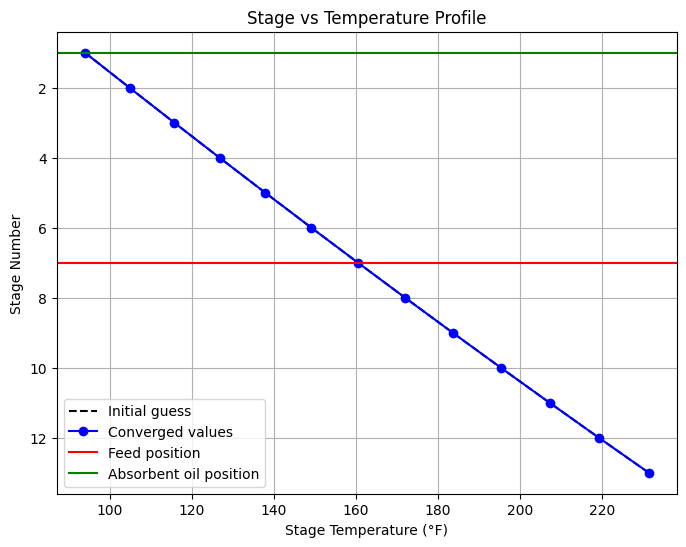

In [126]:
import numpy as np
import matplotlib.pyplot as plt

def k_values(temperature):
    """
    Estimate equilibrium constants (K-values) for components at given temperature (°F).
    Simplified empirical correlation (to be refined for real-world applications).
    """
    return {
        'C1': np.exp(2.0 - 3000 / (temperature + 460)),
        'C2': np.exp(1.5 - 2500 / (temperature + 460)),
        'C3': np.exp(1.0 - 2000 / (temperature + 460)),
        'nC4': np.exp(0.8 - 1800 / (temperature + 460)),
        'nC5': np.exp(0.6 - 1500 / (temperature + 460))
    }

def update_temperatures(temps, vapor_flows, liquid_flows):
    """
    Iteratively update stage temperatures using equilibrium constraints.
    """
    new_temps = temps.copy()
    for i in range(len(temps)):
        k_vals = k_values(temps[i])
        avg_k = np.mean(list(k_vals.values()))
        new_temps[i] = temps[i] * (1 + 0.05 * (avg_k - 1))  # Adjust based on K-value deviation
    return new_temps

def sc_method(iterations=10, tol=1e-3):
    """
    Solve the deethanizer column using Simultaneous-Correction (SC) Method.
    """
    stages = 13
    initial_temps = np.linspace(150, 350, stages)  # Initial guesses from problem statement
    vapor_flows = np.linspace(700, 770, stages)   # Initial vapor flow estimates
    liquid_flows = np.linspace(530, 600, stages)  # Initial liquid flow estimates
    
    for _ in range(iterations):
        new_temps = update_temperatures(initial_temps, vapor_flows, liquid_flows)
        
        if np.max(np.abs(np.array(new_temps) - np.array(initial_temps))) < tol:
            break  # Convergence achieved
        initial_temps = new_temps.copy()
    
    reboiler_duty = 770 * (new_temps[-1] - 105) * 0.8  # Approximate reboiler duty calc
    
    return initial_temps, new_temps, vapor_flows, liquid_flows, reboiler_duty

# Run the simulation
initial_temps, temperatures, vapor_flows, liquid_flows, reboiler_duty = sc_method()

# Print formatted results
print("Stage-wise Temperatures (°F):")
for i, temp in enumerate(temperatures):
    print(f"Stage {i+1}: {temp:.2f} °F")

print("\nVapor and Liquid Flow Rates (lbmol/h):")
for i in range(len(vapor_flows)):
    print(f"Stage {i+1}: V = {vapor_flows[i]:.2f}, L = {liquid_flows[i]:.2f}")

print("\nEstimated Reboiler Duty:")
print(f"Q_reboiler = {reboiler_duty:.2f} BTU/h")

# Plot the stage vs temperature graph
stages = np.arange(1, 14)
plt.figure(figsize=(8, 6))
plt.plot(initial_temps, stages, 'k--', label='Initial guess')
plt.plot(temperatures, stages, 'bo-', label='Converged values')
plt.axhline(y=7, color='r', linestyle='-', label='Feed position')
plt.axhline(y=1, color='g', linestyle='-', label='Absorbent oil position')
plt.gca().invert_yaxis()  # Invert y-axis so stage 1 is at the top
plt.xlabel('Stage Temperature (°F)')
plt.ylabel('Stage Number')
plt.title('Stage vs Temperature Profile')
plt.legend()
plt.grid()
plt.show()


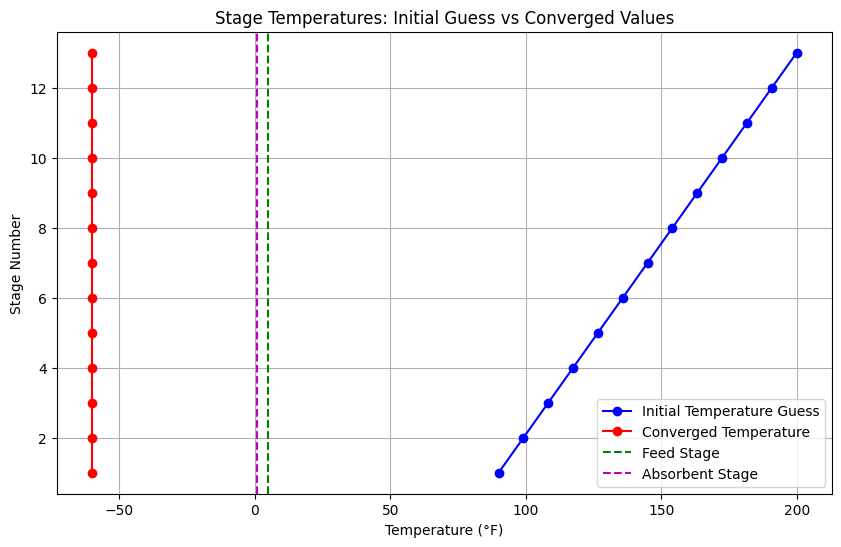

Stage Temperatures (°F): [-60. -60. -60. -60. -60. -60. -60. -60. -60. -60. -60. -60. -60.]
Vapor Flow Rates (lbmol/h): [-3.33268626e-10 -6.94281654e-10 -1.01644401e-09 -1.23482516e-09
 -1.32373072e-09 -1.36238787e-09 -1.54974733e-09 -2.11667405e-09
 -3.12552771e-09 -4.24961762e-09 -4.75923658e-09 -3.94793291e-09
 -1.89542609e-09]
Liquid Flow Rates (lbmol/h): [-3.61012947e-10 -6.83174815e-10 -9.01554599e-10 -9.90460689e-10
 -1.02911791e-09 -1.21647730e-09 -1.78340401e-09 -2.79225780e-09
 -3.91634811e-09 -4.42596693e-09 -3.61466410e-09 -1.56215716e-09
  3.33268731e-10]
Reboiler Duty (BTU/h): -1.8954260851392138e-06


In [134]:
import numpy as np
from scipy.optimize import fsolve
import matplotlib.pyplot as plt

# Constants and initial data
R = 1.987  # Universal gas constant in cal/(mol·K)
components = ['C1', 'C2', 'C3', 'nC4', 'nC5', 'nC10']
feed_flow = np.array([160.0, 370.0, 240.0, 25.0, 5.0, 0.0])  # lbmol/h
absorbent_flow = np.array([0.15, 2.36, 0.0, 0.0, 0.0, 497.49])  # lbmol/h
total_flow = feed_flow + absorbent_flow

# Initial guesses for temperatures and flow rates
N_stages = 13
T_guess = np.linspace(90, 200, N_stages)  # Linear temperature profile
V_guess = np.full(N_stages, 100.0)  # Vapor flow rates
L_guess = np.full(N_stages, 100.0)  # Liquid flow rates

# Define the MESH equations
def mesh_equations(variables):
    T = variables[:N_stages]
    V = variables[N_stages:2*N_stages]
    L = variables[2*N_stages:3*N_stages]
    residuals = np.zeros(3 * N_stages)
    
    for i in range(N_stages):
        # Material balance
        residuals[i] = L[i] + V[i] - (L[i-1] if i > 0 else 0) - (V[i+1] if i < N_stages-1 else 0)
        
        # Equilibrium relationships (simplified)
        K = np.exp(5.0 - 2000.0 / (T[i] + 460.0))  # Simplified K-value calculation
        residuals[N_stages + i] = V[i] * K - L[i]
        
        # Summation
        residuals[2*N_stages + i] = np.sum(K) - 1.0
        
        # Heat balance (simplified)
        # Ensure we do not exceed the residuals array size
        if 3*N_stages + i < len(residuals):
            residuals[3*N_stages + i] = V[i] * 1000.0 - L[i] * 800.0  # Simplified enthalpy calculation
    
    return residuals

# Solve the system
initial_guess = np.concatenate([T_guess, V_guess, L_guess])
solution = fsolve(mesh_equations, initial_guess)

# Extract results
T_solution = solution[:N_stages]
V_solution = solution[N_stages:2*N_stages]
L_solution = solution[2*N_stages:3*N_stages]

# Plotting
stages = np.arange(1, N_stages + 1)
feed_stage = 5  # Example feed stage
absorbent_stage = 1  # Example absorbent stage

plt.figure(figsize=(10, 6))
plt.plot( T_guess,stages, 'bo-', label='Initial Temperature Guess')
plt.plot(T_solution,stages,  'ro-', label='Converged Temperature')
plt.axvline(x=feed_stage, color='g', linestyle='--', label='Feed Stage')
plt.axvline(x=absorbent_stage, color='m', linestyle='--', label='Absorbent Stage')
plt.ylabel('Stage Number')
plt.xlabel('Temperature (°F)')
plt.title('Stage Temperatures: Initial Guess vs Converged Values')
plt.legend()
plt.grid(True)
plt.show()

print("Stage Temperatures (°F):", T_solution)
print("Vapor Flow Rates (lbmol/h):", V_solution)
print("Liquid Flow Rates (lbmol/h):", L_solution)

# Calculate reboiler duty (simplified)
reboiler_duty = V_solution[-1] * 1000.0  # Simplified calculation
print("Reboiler Duty (BTU/h):", reboiler_duty)